In [39]:
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp
import jax
from jax import Array
import numpy

jax.config.update("jax_enable_x64", True)

import zodiax as zdx
import optax

import dLux as dl
import dLux.utils as dlu

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

In [40]:
wf_wid = 512    # width of propagated wavefront
wid = 128       # image size
oversample = 4  # image oversample

nwavels = 50    # number of propagated wavelengths
nbasis=50       # number of basis modes (<= number of wavelengths )

In [41]:
# aperture with spiders.  any perceived resemblance to a real instrument is purely coincidental
optics = dl.AngularOpticalSystem(
    512,
    2.4,
    [
        dl.CircularAperture(radius=1.2, normalise=True), 
        dl.CircularAperture(radius=0.372*1.2, occulting=True),
        dl.Spider(width = 0.077*1.2, angles = np.asarray([0, 90, 180, 270])+45),
    ],
    wid,
    0.0432,
    oversample)

# simple downsampling detector
detector = dl.LayeredDetector(
    [dl.Downsample(oversample)]
)

In [42]:
# combined spectrum that accounts for both instrument filter transmission and source spectrum
# this is kind of unnecessary since you could just multiply the basis vectors by the filter
# transmission beforehand, but oh well it exists now
class CombinedSpectrum(dl.Spectrum):
    wavelengths: Array
    filt_weights: Array
    basis_weights: Array

    def __init__(self, wavels, filt_weights, basis_weights):
        self.filt_weights = np.asarray(filt_weights, float)
        self.wavelengths = np.asarray(wavels, dtype=float)
        self.basis_weights = np.asarray(basis_weights, dtype=float)

    @property
    def spec_weights(self):
        pass

    @property
    def weights(self):
        weights = self.filt_weights*self.spec_weights()
        return weights/weights.sum()

    @property
    def flux(self):
        return np.sum(self.spec_weights())

    def normalise(self):
        return self

# basis spectrum - allows arbitrary fixed bases to be used instead of a wavelength basis
# takes in an extra argument which is a matrix of basis vectors, with layout matching
# whatever np.linalg.eig does (i.e. basis[:,i] is the ith basis vector).  basis vectors 
# span the log spectrum to ensure positivity.  
class CombinedBasisSpectrum(CombinedSpectrum):
    basis_vects: Array
    def __init__(self, wavels, filt_weights, basis_weights, basis):
        self.basis_vects = np.asarray(basis)
        super().__init__(wavels, filt_weights, basis_weights)
    
    def spec_weights(self):
        return 10**np.sum(self.basis_vects*self.basis_weights, axis=1)

# simple function to build the basis of the Discrete Cosine Transform, which is just
# a bunch of cosines of increasing frequency.  other useful bases like a polynomial 
# basis could be constructed similarly
def build_dct_basis(nx, nf):
    xs = np.arange(nx)*2*np.pi/nx
    return jax.vmap(lambda i, x: np.cos(x * i/2), in_axes=(0,None), out_axes = (1))(np.arange(nf), xs)


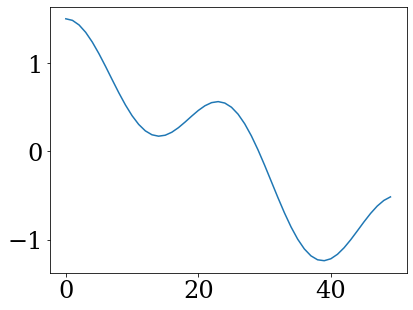

In [43]:
# an example of projecting onto the DCT basis, making two cosines of different frequencies
plt.plot(np.sum(build_dct_basis(50, 5)*np.asarray([0, 1, 0, 0, 0.5]), axis=1))

In [44]:
# basically the F110W wavelength range, with a flat bandpass
wavelengths = np.linspace(0.9, 1.4, nwavels)*1e-6
bandpass = np.ones_like(wavelengths)

# dct spectrum in case you want it
spectrum_fourier = CombinedBasisSpectrum(wavelengths, bandpass, np.ones(nbasis), build_dct_basis(nwavels, nbasis))
# simple wavelength bin basis, used for constructing the eigenbasis
spectrum_bin = CombinedBasisSpectrum(wavelengths, bandpass, np.ones(nbasis), np.eye(nbasis))
# fisher eigenbasis, loads previously created eigenmodes.  need to run the notebook to generate eigenmodes before uncommenting this
#spectrum_eigen = CombinedBasisSpectrum(wavelengths, np.ones_like(wavelengths), np.ones(nbasis), eigenmodes[:,:nbasis])

source = dl.PointSource(position=(0,0), flux=1, spectrum=spectrum_bin) # simple source at the origin

In [45]:
instrument = dl.Telescope(optics, source, detector)

In [46]:
# takes in spectrum vector and spits out a PSF
def model_psf(spectrum):
    telescope = instrument.set("source.spectrum.basis_weights", spectrum)
    telescope = telescope.set("source.flux", telescope.get("source.spectrum").flux) # compute flux from spectrum
    return telescope.model()

In [47]:
# simple flat spectrum with lots of SNR
injected_spectrum = np.ones(nbasis)*50
# a slightly curved spectrum in the eigenbasis
#injected_spectrum = np.zeros(nbasis).at[0].set(-40).at[1].set(0.5)

# simulate actual data
img = model_psf(injected_spectrum)
err = np.sqrt(img + 5**2)
data = jr.normal(jr.key(0),img.shape)*err + img

In [48]:
# can plot eigenbasis spectrum to check if it is working
#plt.plot(10**np.sum(eigenmodes[:,:nbasis]*injected_spectrum, axis=1))

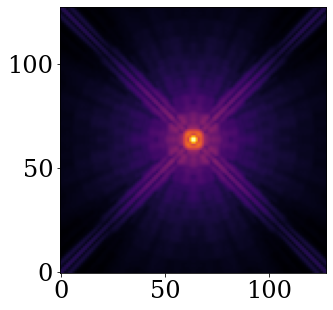

In [49]:
plt.imshow(data**0.125) # here's the injected psf

In [50]:
# does (up to a sign) what it says on the tin
def likelihood(spectrum, data, err):
    psf = model_psf(spectrum)
    return -np.sum(jsp.stats.norm.logpdf(psf, data, err))

In [51]:
# also does what it says on the tin.  beware ram usage
hessian = jax.hessian(likelihood)(injected_spectrum, data, err)

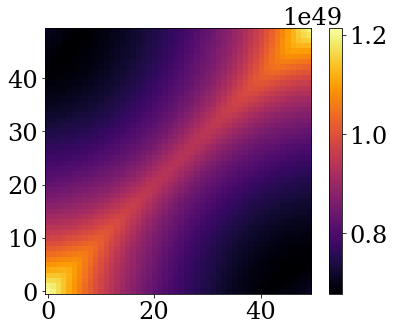

In [52]:
plt.imshow(hessian)
plt.colorbar()

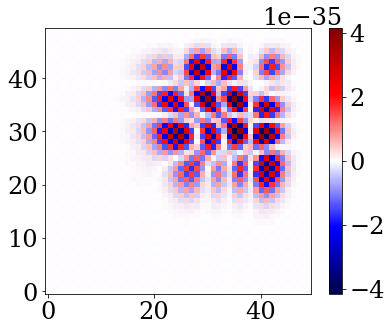

In [53]:
# covariance matrix.  more helpful when looking at the eigenbasis
spectrum_cov = np.linalg.inv(hessian)[:]
plt.imshow(spectrum_cov, cmap='seismic', vmin=-np.max(np.abs(spectrum_cov)), vmax=np.max(np.abs(spectrum_cov)))
plt.colorbar()

Text(0, 0.5, 'Eigenvalue')

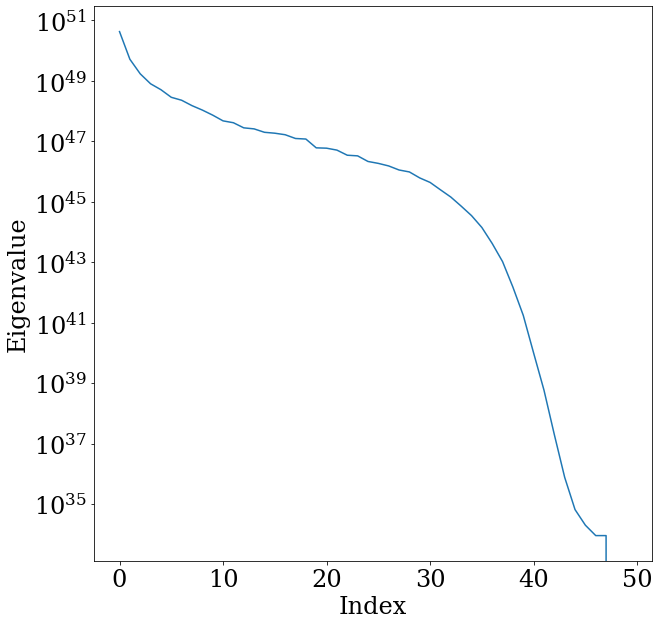

In [54]:
plt.figure(figsize=(10,10))
plt.semilogy(np.real(np.linalg.eig(hessian)[0].sort()[::-1]))
plt.xlabel("Index")
plt.ylabel("Eigenvalue")

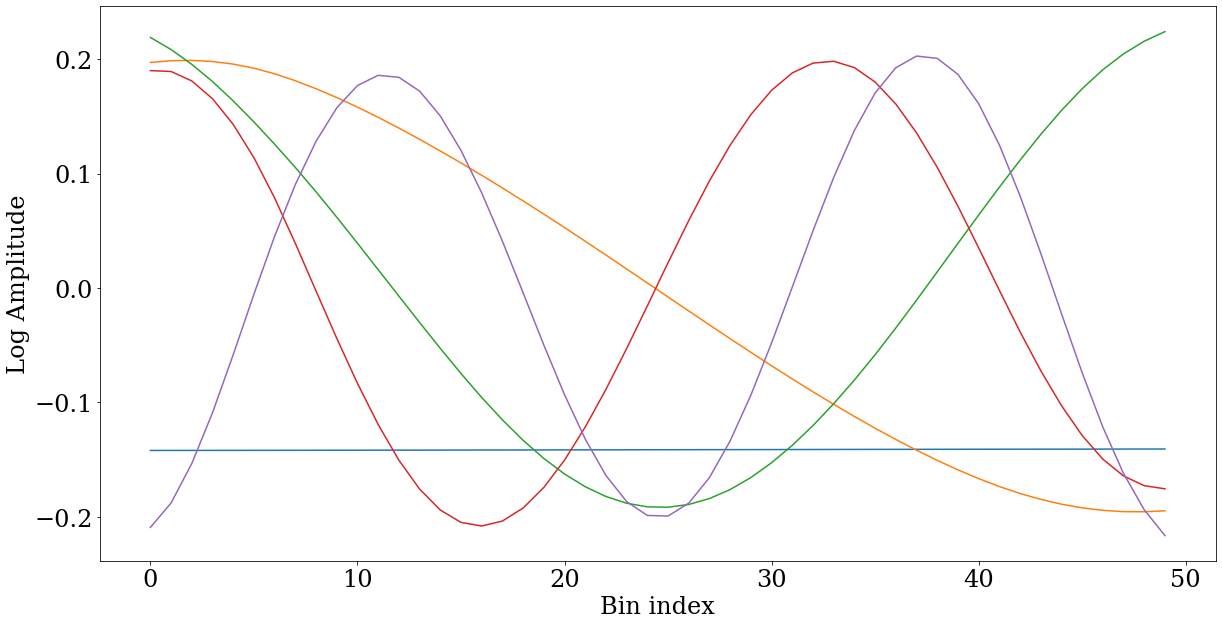

In [60]:
vals, vects = np.linalg.eig(hessian)

order = np.argsort(vals)[::-1]

plt.figure(figsize=(20,10))
plt.xlabel("Bin index")
plt.ylabel("Log Amplitude")
#plt.title("First 5 Fisher Eigenmodes")

for i in range(5):
    plt.plot(np.real(vects[:,order[i]]))



In [56]:
# UNCOMMENT THIS TO SAVE EIGENMODES IF YOU WANT TO RE-RUN USING THE FISHER EIGENBASIS
#eigenmodes = np.real(vects)

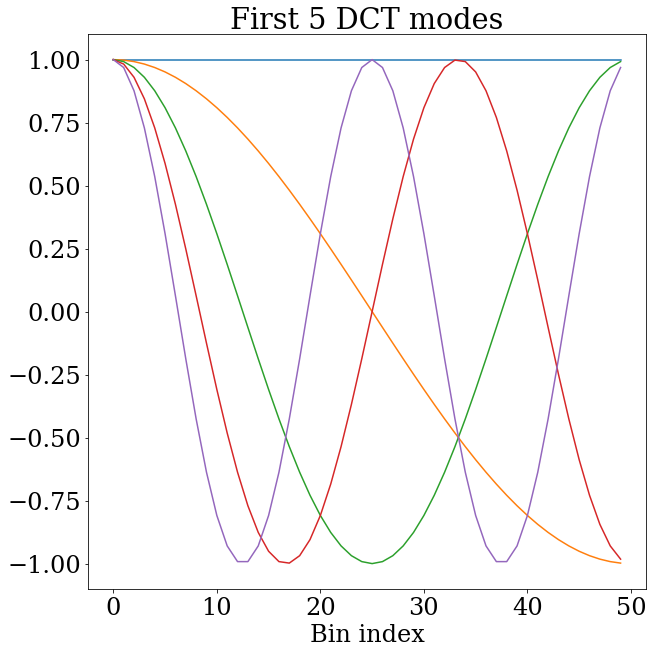

In [57]:
# for comparison this is what the DCT basis looks like.  it's really close

vals, vects = np.linalg.eig(hessian)

order = np.argsort(vals)[::-1]

plt.figure(figsize=(10,10))
plt.xlabel("Bin index")
plt.title("First 5 DCT modes")

for i in range(5):
    plt.plot(build_dct_basis(50, 50)[:,i])